In [1]:
!curl -fsSL https://ollama.com/install.sh | sh
!nohup ollama serve > output.log 2>&1 &
!ollama pull phi4

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling fd7b6731c33c:   0% ▕▏ 2.2 MB/9.1 GB                  pulling manifest 
pulling fd7b6731c33c:   0% ▕▏  30 MB/9.1 GB                  pulling manifest 
pulling fd7b6731c33c:   1% ▕▏  48 MB/9.1 GB                  pulling manifest 
pulling fd7b6731c33c:   1% ▕▏  92 MB/9.1 GB                  pulling manifest 
pulling fd7b6731c33c:   1% ▕▏ 119 MB/9.1 GB                 

In [2]:
!pip install ollama faiss-cpu sentence-transformers numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [3]:
import ollama
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import time
import logging
from typing import List, Tuple
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


## **Unoptimized Agent**

In [4]:
class SimpleAgent:
    def __init__(self):
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.dimension = 384  # Dimension of the embedding model
        self.index = faiss.IndexFlatL2(self.dimension)
        self.documents = []
        self.token_usage = 0
        self.query_times = []

    def embed_text(self, text: str) -> np.ndarray:
        """Generate embedding for a given text."""
        return self.embedding_model.encode([text])[0]

    def add_document(self, document: str):
        """Add a document to the FAISS index."""
        start_time = time.time()
        embedding = self.embed_text(document)
        self.index.add(np.array([embedding], dtype=np.float32))
        self.documents.append(document)
        logger.info(f"Added document. Time: {time.time() - start_time:.4f}s")

    def query(self, question: str, k: int = 1) -> Tuple[str, int]:
        """Query the agent with a question."""
        start_time = time.time()

        # Generate embedding for the question
        question_embedding = self.embed_text(question)

        # Search FAISS index
        distances, indices = self.index.search(np.array([question_embedding], dtype=np.float32), k)

        # Retrieve relevant documents
        context = [self.documents[idx] for idx in indices[0] if idx < len(self.documents)]
        context_text = "\n".join(context)

        # Prepare prompt (unoptimized: verbose and redundant)
        prompt = f"""
        You are a helpful assistant. Given the following context and question, provide a detailed answer.

        Context:
        {context_text}

        Question:
        {question}

        Please provide a comprehensive response with all relevant details.
        """

        # Call Ollama Phi-4
        response = ollama.chat(
            model='phi4',
            messages=[{'role': 'user', 'content': prompt}]
        )

        # Track token usage (approximate)
        prompt_tokens = len(prompt.split())
        response_tokens = len(response['message']['content'].split())
        total_tokens = prompt_tokens + response_tokens
        self.token_usage += total_tokens

        # Track query time
        query_time = time.time() - start_time
        self.query_times.append(query_time)

        logger.info(f"Query processed. Time: {query_time:.4f}s, Tokens: {total_tokens}")

        return response['message']['content'], total_tokens

    def get_performance_metrics(self) -> dict:
        """Return performance metrics."""
        return {
            'total_token_usage': self.token_usage,
            'average_query_time': np.mean(self.query_times) if self.query_times else 0,
            'number_of_queries': len(self.query_times)
        }

## **Optimized Agent**

**Optimization techniques used:**


1.   Concise prompting
2.   Context window optimization with last Q&A
3.   Memory and state management
4.   Fallback strategy



In [5]:
class OptimizedAgent:
  def __init__(self):
    self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    self.dimension = 384
    self.index = faiss.IndexFlatL2(self.dimension)
    self.documents = []
    self.token_usage = 0
    self.query_times = []
    self.memory = []
    self.last_qa_pair = ""

  def embed_text(self, text: str) -> np.ndarray:
    return self.embedding_model.encode([text])[0]

  def add_document(self, document: str):
    embedding = self.embed_text(document)
    self.index.add(np.array([embedding], dtype=np.float32))
    self.documents.append(document)

  def query(self, question: str, k: int = 1) -> Tuple[str, int]:
    start_time = time.time()
    question_embedding = self.embed_text(question)
    distances, indices = self.index.search(np.array([question_embedding], dtype=np.float32), k)
    context = [self.documents[idx] for idx in indices[0] if idx < len(self.documents)]
    context_text = "\n".join(context)

    # context window with last Q&A pair
    context_text += f"\nPrevious Q&A: \n {self.last_qa_pair}" if self.last_qa_pair else ""

    # Concise prompting
    prompt = f"""
    You are a knowledgable assistant. Given the following context and question, provide answer in one or two sentences.

    Context:
    {context_text}

    Question:
    {question}

    Provide accurate answer.
    """

    # fallback strategy
    try:
      response = ollama.chat(
          model='phi4',
          messages=[{'role': 'user', 'content': prompt}]
      )
      answer = response['message']['content'].strip()
    except Exception as e:
      logger.warning("Model failed ! Usinf fallback response.")
      answer = "Sorry, I'm unable to answer the question right now."


    self.last_qa_pair = f"Q: {question}\nA: {answer}"
    self.memory.append(self.last_qa_pair)

    # memory and state management
    if len(self.memory) > 5:
      self.memory.pop(0)
    prompt = f"{' '.join(self.memory)}"


    prompt_tokens = len(prompt.split())
    response_tokens = len(answer.split())
    total_tokens = prompt_tokens + response_tokens
    self.token_usage += total_tokens


    query_time = time.time() - start_time
    self.query_times.append(query_time)

    return answer, total_tokens

  def get_performance_metrics(self) -> dict:
    return {
        'total_token_usage': self.token_usage,
        'average_query_time': np.mean(self.query_times) if self.query_times else 0,
        'number_of_queries': len(self.query_times)
    }

In [6]:
def compare_agents(unopt_tokens, opt_tokens, unopt_times, opt_times, queries):


  x = list(range(len(queries)))
  plt.figure(figsize=(12, 6))


  plt.subplot(1,2,1)
  plt.plot(x, unopt_times, label='Unoptimized', marker='o')
  plt.plot(x, opt_times, label='Optimized', marker='o')
  plt.xlabel('Query Index')
  plt.ylabel('Query Time (seconds)')
  plt.title('Query Time Comparison')
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(x, unopt_tokens, label='Unoptimized', marker='o')
  plt.plot(x, opt_tokens, label='Optimized', marker='o')
  plt.xlabel('Query Index')
  plt.ylabel('Token Usage')
  plt.title('Token Usage Comparison')
  plt.legend()

  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Query: What is the capital of France?
Unoptimized Answer: The capital of France is Paris. Here are some comprehensive details about Paris:

1. **Historical Significance**: 
   - Paris has been an important city for centuries, serving as the center of French culture and politics since the Middle Ages.
   - It was founded by a Celtic tribe called the Parisii around 250 BC.

2. **Geography**:
   - Located in the north-central part of France, on the Seine River.
   - The city covers an area of about 105 square kilometers (41 square miles).

3. **Population**:
   - As of recent estimates, the population of Paris is approximately 2.1 million within its administrative limits.
   - Including suburbs, the metropolitan area has over 12 million residents.

4. **Economy**:
   - Paris is a global hub for art, fashion, gastronomy, and culture.
   - It hosts numerous multinational corporations, banks, and research centers.

5. **Cultural Influence**:
   - Known as "The City of Light" (La Ville Lumièr

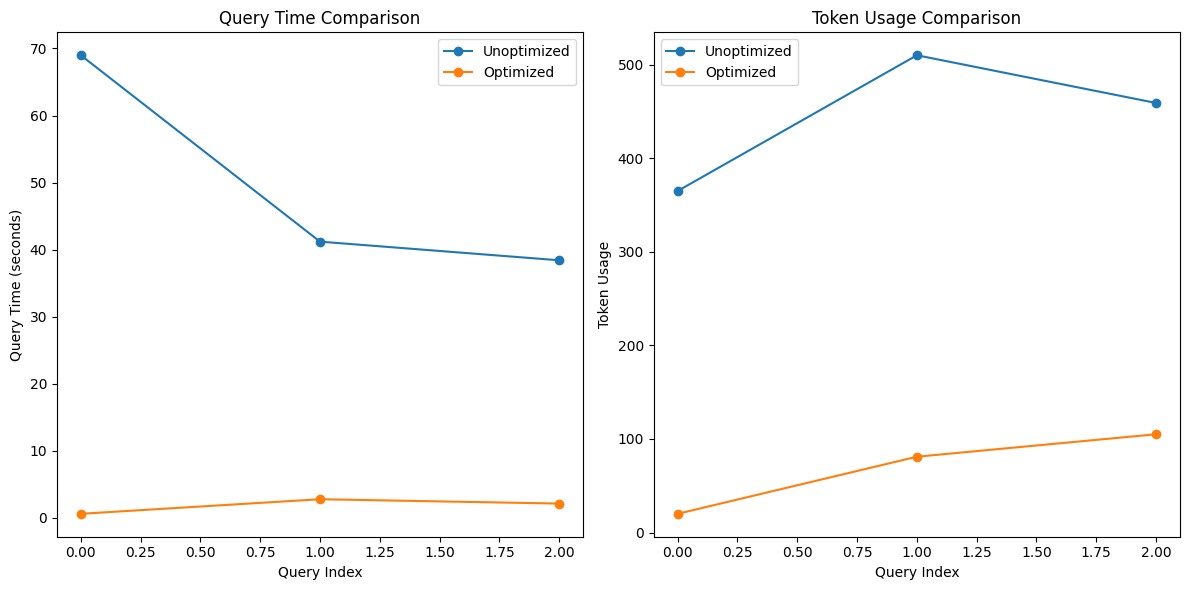

In [7]:
if __name__ == "__main__":
    unoptimized_agent = SimpleAgent()
    optimized_agent = OptimizedAgent()

    # Add sample documents
    documents = [
        "The capital of France is Paris.",
        "Python is a popular programming language.",
        "The sun is a star."
    ]

    for doc in documents:
        unoptimized_agent.add_document(doc)
        optimized_agent.add_document(doc)

    # Test queries
    queries = [
        "What is the capital of France?",
        "What is Python?",
        "Is the sun a star?"
    ]

    unopt_answers, opt_answers = [], []
    unopt_tokens, opt_tokens = [], []
    unopt_times, opt_times = [], []

    for query in queries:
        unopt_start_time = time.time()
        unoptimized_answer, unoptimized_tokens = unoptimized_agent.query(query)
        unopt_time = time.time() - unopt_start_time

        opt_start_time = time.time()
        optimized_answer, optimized_tokens = optimized_agent.query(query)
        opt_time = time.time() - opt_start_time

        unopt_answers.append(unoptimized_answer)
        opt_answers.append(optimized_answer)
        unopt_tokens.append(unoptimized_tokens)
        opt_tokens.append(optimized_tokens)
        unopt_times.append(unopt_time)
        opt_times.append(opt_time)


        print(f"Query: {query}")
        print(f"Unoptimized Answer: {unoptimized_answer}")
        print(f"Tokens used by unoptimized agent: {unoptimized_tokens}\n")
        print(f"Optimied Answer: {optimized_answer}")
        print(f"Tokens used by optimized agent: {optimized_tokens}\n")


    compare_agents(unopt_tokens, opt_tokens, unopt_times, opt_times, queries)
